In [1]:
# started here https://medium.com/@tomgrek/building-your-first-neural-net-from-scratch-with-pytorch-56b0e9c84d54

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torch.optim as optim
import numpy as np
import copy

%matplotlib

Using matplotlib backend: MacOSX


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,64)
        self.fc2 = nn.Linear(64,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
    
net = Net()
#optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum = .05)
optimizer = optim.Adam(net.parameters(), lr=0.01)



In [3]:
class SkipNet(nn.Module):
    def __init__(self):
        super(SkipNet, self).__init__()
        self.fc1 = nn.Linear(1,64)
        self.fc2 = nn.Linear(64,1)
        self.linear_gain = nn.Linear(1,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x)))) + self.linear_gain(x) 
        return x
    
skipnet = SkipNet()
#skipoptimizer = optim.SGD(net.parameters(), lr=0.01, momentum = .05)
skipoptimizer = optim.Adam(skipnet.parameters(), lr=0.01)

In [4]:
def criterion(out, label):
    return (label - out)**2

def skipcriterion(out, label):
    return (label - out)**2 + (torch.abs(net.fc1.weight).sum() + torch.abs(net.fc2.weight).sum()) / 2048

#data = [(1,3), (2,6), (3,9), (4,12), (5,15), (6,18)]

num_points = 100
input_data = [x for x in range(0,num_points)]
linear_data = [(3*x) for x in range(0,num_points)]
#plt.plot(input_data, linear_data)



# small experiment I ran to add a quadratic disturbance to some linear data, to see if our network can handle that
quad_points = 25
scaling_factor = .15
quad = [-scaling_factor*(x - quad_points/2)**2 + scaling_factor*(quad_points/2)**2 for x in range(0,quad_points)]

output_data = copy.deepcopy(linear_data)


start_point = 30
for i in range(0, quad_points):
    output_data[i + start_point] = linear_data[i + start_point] + quad[i]

#plt.plot(quad)
#plt.plot(output_data)



In [5]:
loss_hist = []
weight_hist1 = []
weight_hist2 = []

#import pdb; pdb.set_trace()

weight_hist1.append(net.fc1.weight.clone())
for epoch in range(100):
    total_loss = 0
    
    for i, data2 in enumerate(zip(input_data, output_data)):
        
        
        X, Y = iter(data2)
        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True).cuda(), Variable(torch.FloatTensor([Y]), requires_grad=False).cuda()
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)

        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
    loss_hist.append(total_loss/len(input_data))
    weight_hist1.append(net.fc1.weight.clone())
    weight_hist2.append(net.fc2.weight.clone())
       

Text(0.5,1,'output')

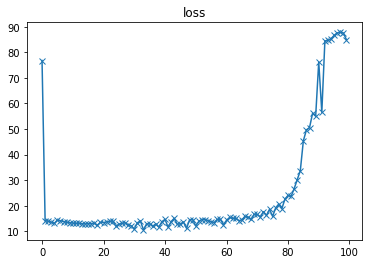

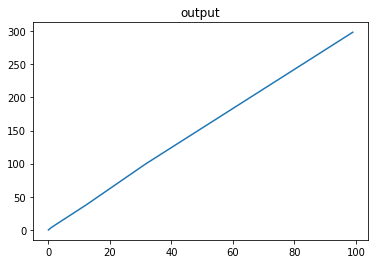

In [6]:
%matplotlib inline
plt.plot(loss_hist, 'x-')
plt.title("loss")
plt.figure()

#torch.all(torch.eq(weight_hist1[0], weight_hist1[121]))

test = net(torch.FloatTensor([1]))
test.data

output = []
for data in input_data:
    output.append(net(torch.FloatTensor([data]).data))

plt.plot(output)
plt.title("output")

In [7]:
# for the skip network
skip_loss_hist = []
skip_weight_hist1 = []
skip_weight_hist2 = []
skip_weight_pass_hist = []


for epoch in range(100):
    total_loss = 0

    for i, data2 in enumerate(zip(input_data, output_data)):
        X, Y = iter(data2)
        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True).cuda(), Variable(torch.FloatTensor([Y]), requires_grad=False).cuda()
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)

        skipoptimizer.zero_grad()
        outputs = skipnet(X)
        loss = skipcriterion(outputs, Y)
        loss.backward()
        skipoptimizer.step()
        total_loss += loss
        
    skip_loss_hist.append(total_loss/len(input_data))
    skip_weight_hist1.append(skipnet.fc1.weight.clone())
    skip_weight_hist2.append(skipnet.fc2.weight.clone())
    skip_weight_pass_hist.append(skipnet.linear_gain.weight.clone())

Text(0.5,1,'output')

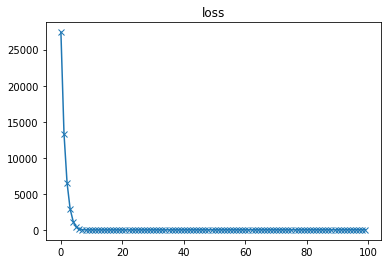

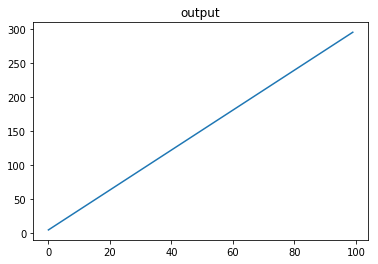

In [8]:
plt.plot(skip_loss_hist, 'x-')
plt.title("loss")
plt.figure()


output = []
for data in input_data:
    output.append(skipnet(torch.FloatTensor([data]).data))

plt.plot(output)
plt.title("output")
#print(skip_weight_hist1[0])
#print(skip_weight_hist1[100])

In [ ]:
loss_hist[1:100]

In [ ]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(1,1)
        self.fc2 = nn.Linear(1,1)
    def forward(self, x):
        x = self.fc1(x)
        return x
    
net = LinearNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)